In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0
DATA_PATH = '/home/liupeng/Desktop/paperFour/data/'
SAMPLE_RATE = 48000

data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender','Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join('/kaggle/input/',dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8: # promeni surprise sa 8 na 0
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        data = data.append({"Emotion": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             },
                             ignore_index = True
                          )
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print("number of files is {}".format(len(data)))
data.head()

number of files is 2880


,Emotion,Emotion intensity,Gender,Path
0,7,normal,male,/home/liupeng/Desktop/paperFour/data/Actor_15/...
1,0,strong,male,/home/liupeng/Desktop/paperFour/data/Actor_15/...
2,7,strong,male,/home/liupeng/Desktop/paperFour/data/Actor_15/...
3,5,normal,male,/home/liupeng/Desktop/paperFour/data/Actor_15/...
4,4,strong,male,/home/liupeng/Desktop/paperFour/data/Actor_15/...


Text(0, 0.5, 'Number of examples')

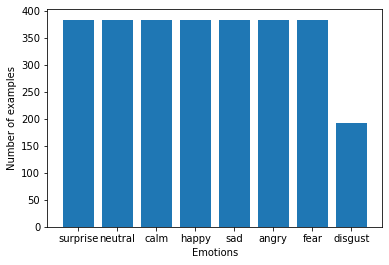

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(8), height=data['Emotion'].value_counts())
ax.set_xticks(ticks=range(8))
ax.set_xticklabels([EMOTIONS[i] for i in range(8)],fontsize=10)
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of examples')

MEL spectrogram shape:  (128, 563)


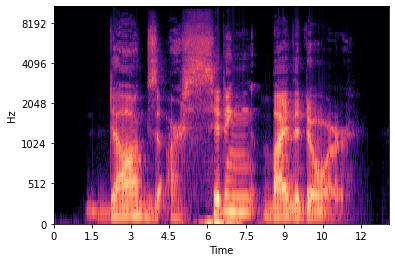

In [5]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

In [6]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    mel_spectrogram = getMELspectrogram(signal, sample_rate=SAMPLE_RATE)
    mel_spectrograms.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,len(data)),end='')

 Processed 2879/2880 files

In [7]:
def addAWGN(signal, num_bits=16, augmented_num=1, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [8]:
for i,signal in enumerate(signals):
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        mel_spectrogram = getMELspectrogram(augmented_signals[j,:], sample_rate=SAMPLE_RATE)
        mel_spectrograms.append(mel_spectrogram)
        data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i,len(signals)),end='')

 Processed 2879/2880 files

In [9]:
X = np.stack(mel_spectrograms,axis=0)
X = np.expand_dims(X,1)
print('Shape of data: ',X.shape)

del mel_spectrograms
del signals

Shape of data:  (5760, 1, 128, 563)


In [ ]:
np.save("filename.npy",a)
b = np.load("filename.npy")

In [10]:
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:,:,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:,:,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:,:,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(4605, 1, 128, 563), Y_train:(4605,)
X_val:(577, 1, 128, 563), Y_val:(577,)
X_test:(578, 1, 128, 563), Y_test:(578,)
Number of unique indexes is 5760, out of 5760


In [18]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
from glob import glob
import os
from tqdm import tqdm_notebook as tqdm
import traceback
from tensorflow.python.keras.layers import *
from tensorflow.python.keras import Sequential,Model
from tensorflow.keras import optimizers as opts
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import regularizers
from keras.utils import np_utils, Sequence

ModuleNotFoundError: No module named 'tensorflow'